1.	Import necessary libraries 

In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2

2.	Set the GPU Memory Consumption Growth to avoid "out of memory" errors when training the model.

In [2]:
# Avoid "out of memory" errors by setting GPU Memory Consumption Growth, so that it will just use as much gpu power as needed for the model. Need to install tensorflow-gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Import the data

3.	Load the dataset and do some preprocessing using the tf.keras.utils.image_dataset_from_directory method, which creates a tensorflow dataset from image files in a directory. The method sets the default batch size to 32 and resizes images to (256,256). The dataset is shuffled by default.

In [3]:
# This keras method loads the dataset and does some preprocessing. E.g., makes the classes, sets a default batch_size=32, image_size=(256,256), shuffles them etc.
data = tf.keras.utils.image_dataset_from_directory('xrays')

Found 5223 files belonging to 2 classes.


4.	Access the data pipeline and generate batches using the as_numpy_iterator() method. Gets one of the generated batches from the data pipeline. The returned batch is in a 2-element list, where the first index is the images and the second index is the label of the class.

In [4]:
# Iterates through the data, accesses the data pipeline and generates batches
data_iterator = data.as_numpy_iterator()

In [5]:
# Gets one of the generated batches. Is returned in a 2 element list, where index 0 is the images and index 1 is the label of the class 
batch = data_iterator.next()

5.	Visualize 4 labeled images in one of the batches.

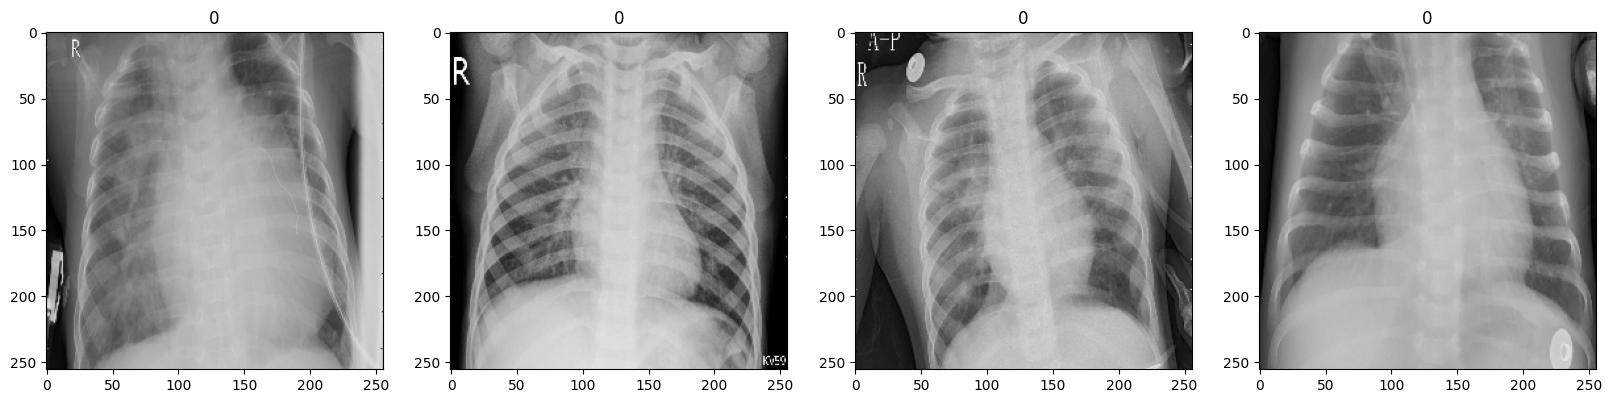

In [6]:
# Create a plot with 4 columns and visualize 4 labeled images in one of the batch
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

6.	Print the list of the classes in the dataset and name them.

In [7]:
# Gets a list of the classes
# Class 1 is Covid
# Class 2 is healthy
print(data.class_names)

['COVID', 'HEALTHY']


# Preprocess and scale the data

In [8]:
batch[0].min()

0.0

In [9]:
batch[0].max()

255.0

7.	Preprocess the data pipeline by mapping through the images ('x') and scaling them so that their pixel values are between 0 and 1.

In [10]:
# Process the data in the pipeline, map through the images ('x') and scale them so that we get a min of 0 and max of 1
data = data.map(lambda x, y: (x / 255, y))

8.	Create and access a batch of scaled data.

In [11]:
# Similar to earlier, creates and accesses a batch
scaled_data_iterator = data.as_numpy_iterator()

In [12]:
batch = scaled_data_iterator.next()

In [13]:
batch[0].min()

0.0

In [14]:
batch[0].max()

1.0

In [15]:
# Check the number of batches
len(data)

164

9.	Split the data batches into training, validation, and testing sets using the take() and skip() methods of TensorFlow. The sizes of each set are determined by the dataset size, with 70% of the data used for training, 20% for validation, and 10% for testing.

In [16]:
# Split the data batches into training, validation and testing with a sum of exactly the number of total batches
training_size = int(len(data)*0.7)
validation_size = int(len(data)*0.2)
testing_size = len(data)-training_size-validation_size

In [17]:
training_size

114

In [18]:
validation_size

32

In [19]:
testing_size

18

In [20]:
training_size+validation_size+testing_size

164

In [21]:
# Use the take and skip method of tf to split and select the batches for training, validation and test
training = data.take(training_size)
validation = data.skip(training_size).take(validation_size)
test = data.skip(training_size+validation_size).take(testing_size)

In [22]:
len(training)

114

In [23]:
len(validation)

32

In [24]:
len(test)

18

# Model

10.	Create a sequential model using the Sequential() method from TensorFlow. This model contains several layers, including convolutional layers, max-pooling layers, flatten layers and dense layers with dropout.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

In [27]:
# Add input layer with filters number, filter resolution, stride of 1, ReLU activation funtion and set the input shape at the image resolution and 3 channels deep
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Layer to downsample the images and condense the information. Divides the input tensor into pooling regions and takes the max value of each region.
model.add(MaxPooling2D())

# More layers
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Some more layers
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# A flatten layer to format the input tensors into 1D so it can be processed better by Dense layers
model.add(Flatten())

# Dense layers, that connects all the neurons in the previous layer into a single output of 0 or 1 through the sigmoid activation, and a dropout layer with a rate of 0.5 to fight overfitting of data.
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

11.	Compile the model using the compile() method with the Adam optimizer, binary cross-entropy loss, and accuracy metrics.

In [28]:
# Keras method to configure the learning process for training. With adam optimizer, loss function for binary classification, and a metric for accuracy.
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train the model

12.	Fit the model to the training data using the fit() method with a set batch size, n epochs, and validation data.

In [30]:
model_training = model.fit(training, epochs=20, batch_size = 128, validation_data=validation, callbacks=[])

Epoch 1/20
114/114 [==============================] - 45s 390ms/step - loss: 0.3301 - accuracy: 0.8610 - val_loss: 0.1391 - val_accuracy: 0.9512
Epoch 2/20
114/114 [==============================] - 46s 403ms/step - loss: 0.1156 - accuracy: 0.9575 - val_loss: 0.1217 - val_accuracy: 0.9570
Epoch 3/20
114/114 [==============================] - 49s 430ms/step - loss: 0.0967 - accuracy: 0.9624 - val_loss: 0.0999 - val_accuracy: 0.9619
Epoch 4/20
114/114 [==============================] - 50s 435ms/step - loss: 0.0729 - accuracy: 0.9737 - val_loss: 0.0787 - val_accuracy: 0.9668
Epoch 5/20
114/114 [==============================] - 48s 414ms/step - loss: 0.0657 - accuracy: 0.9759 - val_loss: 0.0898 - val_accuracy: 0.9639
Epoch 6/20
114/114 [==============================] - 48s 416ms/step - loss: 0.0474 - accuracy: 0.9825 - val_loss: 0.0771 - val_accuracy: 0.9668
Epoch 7/20
114/114 [==============================] - 49s 421ms/step - loss: 0.0306 - accuracy: 0.9888 - val_loss: 0.1129 - val_ac

In [31]:
model_training.history

{'loss': [0.33005061745643616,
  0.11561498790979385,
  0.09665749222040176,
  0.07294143736362457,
  0.06569459289312363,
  0.04744011163711548,
  0.030642690137028694,
  0.02402879111468792,
  0.03443104773759842,
  0.01970071531832218,
  0.01406038086861372,
  0.017302585765719414,
  0.00917164795100689,
  0.00420124689117074,
  0.0036990672815591097,
  0.013162699528038502,
  0.009668989107012749,
  0.0015403792494907975,
  0.0006466799532063305,
  0.009728428907692432],
 'accuracy': [0.8610197305679321,
  0.9575109481811523,
  0.9624451994895935,
  0.9736841917037964,
  0.9758771657943726,
  0.9824561476707458,
  0.9887609481811523,
  0.9909539222717285,
  0.9851973652839661,
  0.9923245906829834,
  0.9947916865348816,
  0.9945175647735596,
  0.9978070259094238,
  0.9983552694320679,
  0.9991776347160339,
  0.9953399300575256,
  0.9967105388641357,
  0.999725878238678,
  0.999725878238678,
  0.9958881735801697],
 'val_loss': [0.13911014795303345,
  0.12167655676603317,
  0.0998954

13.	Plot the loss and validation loss over epochs.

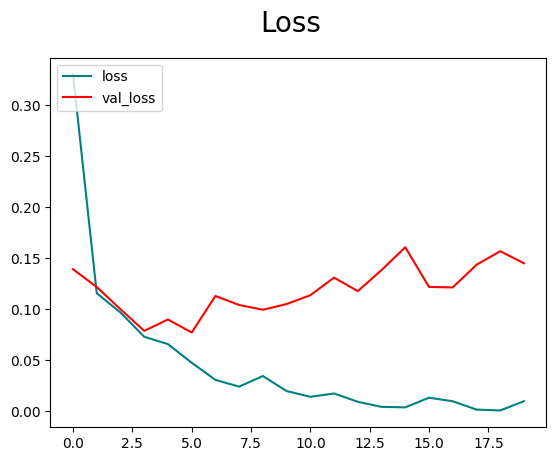

In [32]:
# Plot of the losses and validation losses
fig = plt.figure()
plt.plot(model_training.history['loss'], color='teal', label='loss')
plt.plot(model_training.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

14.	Plot the accuracy and validation accuracy over epochs.

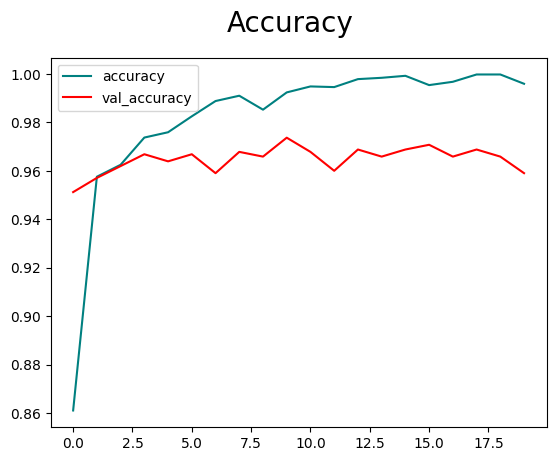

In [33]:
# Plot of accuracy and validation accuracy
fig = plt.figure()
plt.plot(model_training.history['accuracy'], color='teal', label='accuracy')
plt.plot(model_training.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluation of the model performance

15.	Create metrics to evaluate the performance of the model, including precision, recall, accuracy, and confusion matrix.

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [35]:
# Create metrics to evaluate the performance
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()
confusion_matrix = tf.zeros(shape=(2,2), dtype=tf.int32)

16.	Loop through the testing set, extracting the data (X) and labels (y), and use the model to predict the labels (yhat) for the input data X. Update the metrics to keep track of the performance and calculate the confusion matrix.

In [36]:
# Loop extracting the data x and labels y and uses the model to predict the labels yhat for input data x. Also, updates the metrics to keep track of the performance and calculates the confusion matrix.
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)
    confusion_matrix += tf.math.confusion_matrix(y, yhat, num_classes=2)

1/1 [==============================] - 0s 48ms/step


17.	Print the precision, recall, and accuracy metrics for the model, and print the confusion matrix.

In [37]:
print(f'Precision is: {precision.result().numpy()}, Recall is: {recall.result().numpy()}, Accuracy is: {accuracy.result().numpy()}')

Precision is: 0.9650349617004395, Recall is: 0.8846153616905212, Accuracy is: 0.9582577347755432


In [38]:
print(confusion_matrix)

tf.Tensor(
[[395   0]
 [154   2]], shape=(2, 2), dtype=int32)


In [39]:
tf.print("Confusion matrix:")
tf.print("  Actual\\Predicted  |  Negative  |  Positive")
tf.print("--------------------+------------+-----------")
tf.print("  Negative          |  ", confusion_matrix[0][0], "  |  ", confusion_matrix[0][1])
tf.print("  Positive          |  ", confusion_matrix[1][0], "  |  ", confusion_matrix[1][1])

Confusion matrix:
  Actual\Predicted  |  Negative  |  Positive
--------------------+------------+-----------
  Negative          |   395   |   0
  Positive          |   154   |   2


# Testing the model

18.	Load the image for classification prediction

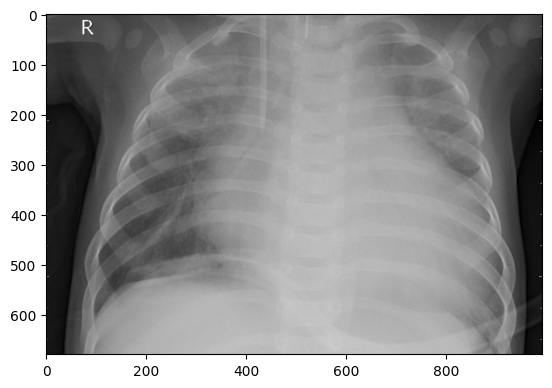

In [40]:
# Load the image and display it
img = cv2.imread('xrays/test.jpeg')
plt.imshow(img)
plt.show()

19.	The image is resized and converted ton a numpy array

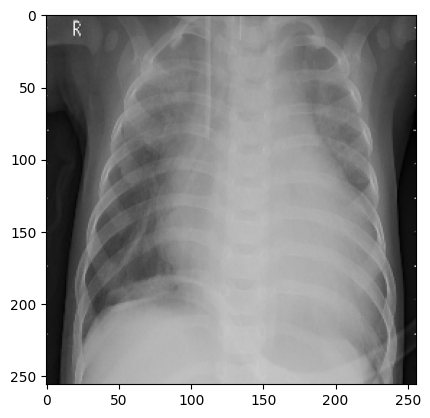

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

20.	Using the loaded image as input, we predict its class. The image is normalized to get a 0<n<1 value for classification.

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 7ms/step


In [43]:
yhat

array([[5.693058e-09]], dtype=float32)

21.	Classify the image

In [44]:
if yhat > 0.5: 
    print(f'Predicted class is Healthy')
else:
    print(f'Predicted class is Covid')

Predicted class is Covid
